In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local") \
    .appName("AppName") \
    .getOrCreate()
from pyspark.sql.functions import split, col, regexp_extract, expr, count, when, asc, year, quarter, month, weekofyear, dayofweek, day

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/16 08:33:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [4]:
from pyspark.sql.types import StructType, StructField, TimestampType, IntegerType, StringType, FloatType, DoubleType

In [27]:
schema = StructType([
    StructField("user_session", StringType(), True),
    StructField("product_id", IntegerType(), True),
    StructField("user_id", IntegerType(), True),
    StructField("event_time", TimestampType(), True),
    StructField("event_type", StringType(), True),
    StructField("category_code", StringType(), True),
    StructField("price", FloatType(), True)
])

In [28]:
purchased = spark.read.csv('purchased_new/purchased.csv', header = True, schema = schema)
noPurchase = spark.read.csv('noPurchase_new/noPurchase.csv', header = True, schema = schema)
purchased.show(5)
noPurchase.show(5)

+--------------------+----------+---------+-------------------+----------+-------------+-----+
|        user_session|product_id|  user_id|         event_time|event_type|category_code|price|
+--------------------+----------+---------+-------------------+----------+-------------+-----+
|00024c6d-5a3c-4f6...| 100040247|518159380|2020-03-03 06:27:00|      view|      apparel|66.67|
|00024c6d-5a3c-4f6...| 100040247|518159380|2020-03-03 06:27:22|      view|      apparel|66.67|
|00024c6d-5a3c-4f6...| 100040247|518159380|2020-03-03 06:28:19|      view|      apparel|66.67|
|00024c6d-5a3c-4f6...| 100040247|518159380|2020-03-03 06:28:29|      cart|      apparel|66.67|
|00024c6d-5a3c-4f6...| 100040247|518159380|2020-03-03 06:29:45|  purchase|      apparel|66.67|
+--------------------+----------+---------+-------------------+----------+-------------+-----+
only showing top 5 rows

+--------------------+----------+---------+-------------------+----------+-------------+------+
|        user_session|pr

In [29]:
purchased.createOrReplaceTempView("purchased")
noPurchase.createOrReplaceTempView("noPurchase")

### purchased feature extraction

In [30]:
# group one purhcase: user session + product_id + purchase_count
purchase_info = spark.sql('''SELECT *,
                                    SUM(CASE 
                                         WHEN lag (event_type = 'purchase') OVER (PARTITION BY user_session, product_id ORDER BY event_time) THEN 1 ELSE 0 
                                        END)
                                      OVER (PARTITION BY user_session, product_id ORDER BY event_time) + 1 AS purchase_count
                             FROM purchased''')
purchase_info.filter(purchase_info.user_session == '5fdba253-fe1e-4bcf-9318-41db593f86da').show()

+--------------------+----------+---------+-------------------+----------+-------------+------+--------------+
|        user_session|product_id|  user_id|         event_time|event_type|category_code| price|purchase_count|
+--------------------+----------+---------+-------------------+----------+-------------+------+--------------+
|5fdba253-fe1e-4bc...|   3601505|518278108|2020-03-29 04:45:27|      view|   appliances|514.56|             1|
|5fdba253-fe1e-4bc...|   3601505|518278108|2020-03-29 04:48:35|      cart|   appliances|514.56|             1|
|5fdba253-fe1e-4bc...|   3601505|518278108|2020-03-29 04:48:51|  purchase|   appliances|514.56|             1|
|5fdba253-fe1e-4bc...|   3601505|518278108|2020-03-29 04:52:07|      view|   appliances|514.56|             2|
|5fdba253-fe1e-4bc...|   3601505|518278108|2020-03-29 04:55:19|      view|   appliances|514.56|             2|
|5fdba253-fe1e-4bc...| 100068589|518278108|2020-03-29 04:27:57|      view| construction|373.21|             1|
|

In [31]:
# add isPurchased and drop rows where contains only view and/or cart
purchase_info.createOrReplaceGlobalTempView('purchase_info')
filtered_info = spark.sql(''' WITH temp AS(
                                    SELECT *,
                                            CASE WHEN event_type = "purchase" THEN 1 ELSE 0 END AS isPurchased
                                    FROM global_temp.purchase_info
                                )
                     SELECT *
                     FROM temp
                     WHERE (user_session, product_id, purchase_count)in (
                                   SELECT user_session, product_id, purchase_count
                                   FROM temp
                                   GROUP BY user_session, product_id, purchase_count
                                   HAVING SUM(isPurchased) > 0)''')
filtered_info.filter(filtered_info.user_session == '5fdba253-fe1e-4bcf-9318-41db593f86da').show()

+--------------------+----------+---------+-------------------+----------+-------------+------+--------------+-----------+
|        user_session|product_id|  user_id|         event_time|event_type|category_code| price|purchase_count|isPurchased|
+--------------------+----------+---------+-------------------+----------+-------------+------+--------------+-----------+
|5fdba253-fe1e-4bc...| 100068589|518278108|2020-03-29 04:27:57|      view| construction|373.21|             1|          0|
|5fdba253-fe1e-4bc...| 100068589|518278108|2020-03-29 04:29:18|      cart| construction|373.21|             1|          0|
|5fdba253-fe1e-4bc...| 100068589|518278108|2020-03-29 04:31:28|  purchase| construction|373.21|             1|          1|
|5fdba253-fe1e-4bc...| 100068589|518278108|2020-03-29 04:32:06|      view| construction|373.21|             2|          0|
|5fdba253-fe1e-4bc...| 100068589|518278108|2020-03-29 04:32:15|      cart| construction|373.21|             2|          0|
|5fdba253-fe1e-4

In [32]:
filtered_info.createOrReplaceTempView('filtered_info')
addedCart = spark.sql(''' 
                          SELECT *,
                              CASE
                                WHEN MAX(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END) OVER (PARTITION BY user_session) = 1
                                     AND event_type = 'purchase' THEN 1
                                WHEN MAX(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END) OVER (PARTITION BY user_session) = 1 THEN 1
                                ELSE 0
                              END AS AddedToCart
                            FROM filtered_info''')

addedCart.show(5)

+--------------------+----------+---------+-------------------+----------+-------------+-----+-----------+--------------+-----------+
|        user_session|product_id|  user_id|         event_time|event_type|category_code|price|isPurchased|purchase_count|AddedToCart|
+--------------------+----------+---------+-------------------+----------+-------------+-----+-----------+--------------+-----------+
|00002b33-422d-4a0...|  19100023|517463118|2020-03-09 16:19:22|      view| construction|65.48|          0|             1|          1|
|00002b33-422d-4a0...|  19100023|517463118|2020-03-09 16:19:45|      view| construction|65.48|          0|             1|          1|
|00002b33-422d-4a0...|  19100023|517463118|2020-03-09 16:28:06|      cart| construction|65.48|          0|             1|          1|
|00002b33-422d-4a0...|  19100023|517463118|2020-03-09 16:28:44|      cart| construction|65.48|          0|             1|          1|
|00002b33-422d-4a0...|  19100023|517463118|2020-03-09 16:29:11

In [33]:
# addedCart if a user_session added certain product to cart
addedCart.createOrReplaceTempView('addedCart')
ViewCount = spark.sql(''' 
                          SELECT *,
                                 SUM(CASE WHEN event_type = 'view' THEN 1 ELSE 0 END)
                                       OVER (PARTITION BY user_session, product_id, purchase_count
                                           ORDER BY event_time) AS count_view
                          FROM addedCart''')
ViewCount.show(5)

+--------------------+----------+---------+-------------------+----------+-------------+-----+-----------+--------------+-----------+----------+
|        user_session|product_id|  user_id|         event_time|event_type|category_code|price|isPurchased|purchase_count|AddedToCart|count_view|
+--------------------+----------+---------+-------------------+----------+-------------+-----+-----------+--------------+-----------+----------+
|00002b33-422d-4a0...|  19100023|517463118|2020-03-09 16:19:22|      view| construction|65.48|          0|             1|          1|         1|
|00002b33-422d-4a0...|  19100023|517463118|2020-03-09 16:19:45|      view| construction|65.48|          0|             1|          1|         2|
|00002b33-422d-4a0...|  19100023|517463118|2020-03-09 16:28:06|      cart| construction|65.48|          0|             1|          1|         2|
|00002b33-422d-4a0...|  19100023|517463118|2020-03-09 16:28:44|      cart| construction|65.48|          0|             1|         

In [34]:
# count # views before one purchase
ViewCount.createOrReplaceTempView('ViewCount')
isStart = spark.sql(''' SELECT *,
                            CASE 
                                WHEN MIN(event_time)                             
                                    OVER(PARTITION BY user_session, product_id, purchase_count ORDER BY event_time) = event_time THEN 1 ELSE 0 
                            END AS isStart
                        FROM ViewCount''')
isStart.show(10)

+--------------------+----------+---------+-------------------+----------+-------------+-----+-----------+--------------+-----------+----------+-------+
|        user_session|product_id|  user_id|         event_time|event_type|category_code|price|isPurchased|purchase_count|AddedToCart|count_view|isStart|
+--------------------+----------+---------+-------------------+----------+-------------+-----+-----------+--------------+-----------+----------+-------+
|00002b33-422d-4a0...|  19100023|517463118|2020-03-09 16:19:22|      view| construction|65.48|          0|             1|          1|         1|      1|
|00002b33-422d-4a0...|  19100023|517463118|2020-03-09 16:19:45|      view| construction|65.48|          0|             1|          1|         2|      0|
|00002b33-422d-4a0...|  19100023|517463118|2020-03-09 16:28:06|      cart| construction|65.48|          0|             1|          1|         2|      0|
|00002b33-422d-4a0...|  19100023|517463118|2020-03-09 16:28:44|      cart| constru

In [35]:
# interval between the first event and the current event within one purchase
isStart.createOrReplaceTempView('isStart')
time_spent_added = spark.sql('''SELECT *,
                                  event_time - min(event_time) 
                                        OVER (PARTITION BY user_session, product_id, purchase_count ORDER BY event_time) AS timeSpent
                                FROM isStart''')
time_spent_added.show(5)

+--------------------+----------+---------+-------------------+----------+-------------+-----+-----------+--------------+-----------+----------+-------+--------------------+
|        user_session|product_id|  user_id|         event_time|event_type|category_code|price|isPurchased|purchase_count|AddedToCart|count_view|isStart|           timeSpent|
+--------------------+----------+---------+-------------------+----------+-------------+-----+-----------+--------------+-----------+----------+-------+--------------------+
|00002b33-422d-4a0...|  19100023|517463118|2020-03-09 16:19:22|      view| construction|65.48|          0|             1|          1|         1|      1|INTERVAL '0 00:00...|
|00002b33-422d-4a0...|  19100023|517463118|2020-03-09 16:19:45|      view| construction|65.48|          0|             1|          1|         2|      0|INTERVAL '0 00:00...|
|00002b33-422d-4a0...|  19100023|517463118|2020-03-09 16:28:06|      cart| construction|65.48|          0|             1|         

In [36]:
# extract day from event_day
AddedDay = time_spent_added.withColumn('dayOfPurchase', day(col('event_time')))
AddedDay.show(5)

+--------------------+----------+---------+-------------------+----------+-------------+-----+-----------+--------------+-----------+----------+-------+--------------------+-------------+
|        user_session|product_id|  user_id|         event_time|event_type|category_code|price|isPurchased|purchase_count|AddedToCart|count_view|isStart|           timeSpent|dayOfPurchase|
+--------------------+----------+---------+-------------------+----------+-------------+-----+-----------+--------------+-----------+----------+-------+--------------------+-------------+
|00002b33-422d-4a0...|  19100023|517463118|2020-03-09 16:19:22|      view| construction|65.48|          0|             1|          1|         1|      1|INTERVAL '0 00:00...|            9|
|00002b33-422d-4a0...|  19100023|517463118|2020-03-09 16:19:45|      view| construction|65.48|          0|             1|          1|         2|      0|INTERVAL '0 00:00...|            9|
|00002b33-422d-4a0...|  19100023|517463118|2020-03-09 16:28:

In [37]:
timeSpent_pur = AddedDay.filter(AddedDay.event_type == 'purchase')
timeSpent_pur = timeSpent_pur.withColumn('timeSpent_sec', expr('cast(timeSpent as long)'))
timeSpent_pur = timeSpent_pur.drop('timeSpent')
timeSpent_pur.show(3)

+--------------------+----------+---------+-------------------+----------+-------------+-----+-----------+--------------+-----------+----------+-------+-------------+-------------+
|        user_session|product_id|  user_id|         event_time|event_type|category_code|price|isPurchased|purchase_count|AddedToCart|count_view|isStart|dayOfPurchase|timeSpent_sec|
+--------------------+----------+---------+-------------------+----------+-------------+-----+-----------+--------------+-----------+----------+-------+-------------+-------------+
|00002b33-422d-4a0...|  19100023|517463118|2020-03-09 16:29:11|  purchase| construction|65.48|          1|             1|          1|         2|      0|            9|          589|
|00007ae6-150b-41f...|   3601365|616389042|2020-03-15 02:39:27|  purchase|   appliances|95.21|          1|             1|          1|         3|      0|           15|          355|
|00024c6d-5a3c-4f6...| 100040247|518159380|2020-03-03 06:29:45|  purchase|      apparel|66.67| 

In [38]:
purchaseToCsv = timeSpent_pur.filter(timeSpent_pur.count_view > '0')
purchaseToCsv.show(5)

+--------------------+----------+---------+-------------------+----------+-------------+------+-----------+--------------+-----------+----------+-------+-------------+-------------+
|        user_session|product_id|  user_id|         event_time|event_type|category_code| price|isPurchased|purchase_count|AddedToCart|count_view|isStart|dayOfPurchase|timeSpent_sec|
+--------------------+----------+---------+-------------------+----------+-------------+------+-----------+--------------+-----------+----------+-------+-------------+-------------+
|00002b33-422d-4a0...|  19100023|517463118|2020-03-09 16:29:11|  purchase| construction| 65.48|          1|             1|          1|         2|      0|            9|          589|
|00007ae6-150b-41f...|   3601365|616389042|2020-03-15 02:39:27|  purchase|   appliances| 95.21|          1|             1|          1|         3|      0|           15|          355|
|00024c6d-5a3c-4f6...| 100040247|518159380|2020-03-03 06:29:45|  purchase|      apparel| 6

In [48]:
purchaseToCsv1 = purchaseToCsv.filter(col('purchase_count') == 1)

In [51]:
purchaseToCsv3 = purchaseToCsv1.drop("purchase_count", "isStart", "event_type")
purchaseToCsv3.show(5)

+--------------------+----------+---------+-------------+------+-----------+-----------+----------+-------------+-------------+
|        user_session|product_id|  user_id|category_code| price|isPurchased|AddedToCart|count_view|dayOfPurchase|timeSpent_sec|
+--------------------+----------+---------+-------------+------+-----------+-----------+----------+-------------+-------------+
|00002b33-422d-4a0...|  19100023|517463118| construction| 65.48|          1|          1|         2|            9|          589|
|00007ae6-150b-41f...|   3601365|616389042|   appliances| 95.21|          1|          1|         3|           15|          355|
|00024c6d-5a3c-4f6...| 100040247|518159380|      apparel| 66.67|          1|          1|         3|            3|          165|
|000298bc-b454-45f...|   1307533|573501390|  electronics|442.74|          1|          1|         2|           10|           42|
|0002f825-fdad-4b7...| 100005682|599277587| construction|170.66|          1|          1|         2|     

### noPurchase feature extraction

In [39]:
noPurchase.show(5)

+--------------------+----------+---------+-------------------+----------+-------------+------+
|        user_session|product_id|  user_id|         event_time|event_type|category_code| price|
+--------------------+----------+---------+-------------------+----------+-------------+------+
|000005c4-64d7-42d...|   8801095|522607116|2020-03-02 07:04:48|      view|  electronics| 24.69|
|000005c4-64d7-42d...|   8801095|522607116|2020-03-02 07:05:05|      view|  electronics| 24.69|
|000005c4-64d7-42d...|   8801095|522607116|2020-03-02 07:05:27|      view|  electronics| 24.69|
|00011676-af2a-4f2...| 100016288|517473310|2020-03-28 16:19:24|      view|         auto|459.47|
|000134c7-bef2-49d...|   9100935|621657817|2020-03-11 06:06:32|      view|    furniture| 19.31|
+--------------------+----------+---------+-------------------+----------+-------------+------+
only showing top 5 rows



In [40]:
noPurchase = noPurchase.withColumn('isPurchased', when(col('event_type') == 'purchase', 1).otherwise(0))
noPurchase.show(5)

+--------------------+----------+---------+-------------------+----------+-------------+------+-----------+
|        user_session|product_id|  user_id|         event_time|event_type|category_code| price|isPurchased|
+--------------------+----------+---------+-------------------+----------+-------------+------+-----------+
|000005c4-64d7-42d...|   8801095|522607116|2020-03-02 07:04:48|      view|  electronics| 24.69|          0|
|000005c4-64d7-42d...|   8801095|522607116|2020-03-02 07:05:05|      view|  electronics| 24.69|          0|
|000005c4-64d7-42d...|   8801095|522607116|2020-03-02 07:05:27|      view|  electronics| 24.69|          0|
|00011676-af2a-4f2...| 100016288|517473310|2020-03-28 16:19:24|      view|         auto|459.47|          0|
|000134c7-bef2-49d...|   9100935|621657817|2020-03-11 06:06:32|      view|    furniture| 19.31|          0|
+--------------------+----------+---------+-------------------+----------+-------------+------+-----------+
only showing top 5 rows



In [41]:
AddedDay = noPurchase.withColumn('eventDay', day(col('event_time')))
AddedDay.show(5)

+--------------------+----------+---------+-------------------+----------+-------------+------+-----------+--------+
|        user_session|product_id|  user_id|         event_time|event_type|category_code| price|isPurchased|eventDay|
+--------------------+----------+---------+-------------------+----------+-------------+------+-----------+--------+
|000005c4-64d7-42d...|   8801095|522607116|2020-03-02 07:04:48|      view|  electronics| 24.69|          0|       2|
|000005c4-64d7-42d...|   8801095|522607116|2020-03-02 07:05:05|      view|  electronics| 24.69|          0|       2|
|000005c4-64d7-42d...|   8801095|522607116|2020-03-02 07:05:27|      view|  electronics| 24.69|          0|       2|
|00011676-af2a-4f2...| 100016288|517473310|2020-03-28 16:19:24|      view|         auto|459.47|          0|      28|
|000134c7-bef2-49d...|   9100935|621657817|2020-03-11 06:06:32|      view|    furniture| 19.31|          0|      11|
+--------------------+----------+---------+-------------------+-

In [42]:
# count # views a user has perfomed on a product during the session
AddedDay.createOrReplaceGlobalTempView('AddedDay')
viewCount = spark.sql(''' 
                          SELECT *,
                                 SUM(CASE WHEN event_type = 'view' THEN 1 ELSE 0 END)
                                       OVER (PARTITION BY user_session, product_id
                                           ORDER BY event_time) AS count_view
                          FROM global_temp.AddedDay''')

viewCount.show(5)

+--------------------+----------+---------+-------------------+----------+-------------+------+-----------+--------+----------+
|        user_session|product_id|  user_id|         event_time|event_type|category_code| price|isPurchased|eventDay|count_view|
+--------------------+----------+---------+-------------------+----------+-------------+------+-----------+--------+----------+
|000005c4-64d7-42d...|   8801095|522607116|2020-03-02 07:04:48|      view|  electronics| 24.69|          0|       2|         1|
|000005c4-64d7-42d...|   8801095|522607116|2020-03-02 07:05:05|      view|  electronics| 24.69|          0|       2|         2|
|000005c4-64d7-42d...|   8801095|522607116|2020-03-02 07:05:27|      view|  electronics| 24.69|          0|       2|         3|
|000019d6-bd38-428...|   1003312|597074100|2020-03-04 06:38:24|      view| construction|707.87|          0|       4|         1|
|00002b33-422d-4a0...|  19100107|517463118|2020-03-09 16:17:37|      view| construction| 48.01|         

In [43]:
viewCount.createOrReplaceGlobalTempView('viewCount')
addedCart = spark.sql(''' 
                          SELECT *,
                              CASE
                                WHEN MAX(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END) OVER (PARTITION BY user_session) = 1
                                     AND event_type = 'purchase' THEN 1
                                WHEN MAX(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END) OVER (PARTITION BY user_session) = 1 THEN 1
                                ELSE 0
                              END AS AddedToCart
                            FROM global_temp.viewCount''')

addedCart.show(5)

+--------------------+----------+---------+-------------------+----------+-------------+------+-----------+--------+----------+-----------+
|        user_session|product_id|  user_id|         event_time|event_type|category_code| price|isPurchased|eventDay|count_view|AddedToCart|
+--------------------+----------+---------+-------------------+----------+-------------+------+-----------+--------+----------+-----------+
|000005c1-b15b-4b6...|  19400025|569095769|2020-03-15 10:46:00|      view|         kids| 692.4|          0|      15|         1|          0|
|000060f8-9e8f-47a...|   1005099|569038711|2020-03-22 05:46:17|      view| construction|144.11|          0|      22|         1|          0|
|00007b08-b24a-49f...|   2403027|569562057|2020-03-09 14:31:01|      view|   appliances| 88.52|          0|       9|         1|          0|
|00007e51-fd38-494...|   1005288|627107707|2020-03-11 16:29:29|      view| construction| 262.3|          0|      11|         1|          0|
|00011676-af2a-4f2..

In [44]:
addedCart.createOrReplaceTempView('addedCart')
isStart = spark.sql(''' SELECT *,
                            CASE 
                                WHEN MIN(event_time) OVER(PARTITION BY user_session, product_id ORDER BY event_time) = event_time  THEN 1 ELSE 0 
                            END AS isStart
                         FROM addedCart''')
isStart.show(5)

+--------------------+----------+---------+-------------------+----------+-------------+------+-----------+--------+----------+-----------+-------+
|        user_session|product_id|  user_id|         event_time|event_type|category_code| price|isPurchased|eventDay|count_view|AddedToCart|isStart|
+--------------------+----------+---------+-------------------+----------+-------------+------+-----------+--------+----------+-----------+-------+
|000005c1-b15b-4b6...|  19400025|569095769|2020-03-15 10:46:00|      view|         kids| 692.4|          0|      15|         1|          0|      1|
|000060f8-9e8f-47a...|   1005099|569038711|2020-03-22 05:46:17|      view| construction|144.11|          0|      22|         1|          0|      1|
|00007b08-b24a-49f...|   2403027|569562057|2020-03-09 14:31:01|      view|   appliances| 88.52|          0|       9|         1|          0|      1|
|00007e51-fd38-494...|   1005288|627107707|2020-03-11 16:29:29|      view| construction| 262.3|          0|     

In [45]:
# interval between the current event and the very first event a user_session has performed on one product
isStart.createOrReplaceTempView('isStart')
time_spent_added = spark.sql('''SELECT *,
                                   (event_time - min(event_time)  OVER (PARTITION BY user_session, product_id ORDER BY event_time)) AS timeSpent
                                FROM isStart''')
time_spent_added.show(5)

+--------------------+----------+---------+-------------------+----------+-------------+------+-----------+--------+----------+-----------+-------+--------------------+
|        user_session|product_id|  user_id|         event_time|event_type|category_code| price|isPurchased|eventDay|count_view|AddedToCart|isStart|           timeSpent|
+--------------------+----------+---------+-------------------+----------+-------------+------+-----------+--------+----------+-----------+-------+--------------------+
|000005c1-b15b-4b6...|  19400025|569095769|2020-03-15 10:46:00|      view|         kids| 692.4|          0|      15|         1|          0|      1|INTERVAL '0 00:00...|
|000060f8-9e8f-47a...|   1005099|569038711|2020-03-22 05:46:17|      view| construction|144.11|          0|      22|         1|          0|      1|INTERVAL '0 00:00...|
|00007b08-b24a-49f...|   2403027|569562057|2020-03-09 14:31:01|      view|   appliances| 88.52|          0|       9|         1|          0|      1|INTERVAL

In [46]:
timeSpent_noPur = time_spent_added.withColumn('timeSpent_sec', expr('cast(timeSpent as long)'))
timeSpent_noPur = timeSpent_noPur.drop('timeSpent')
timeSpent_noPur.show(5)

+--------------------+----------+---------+-------------------+----------+-------------+------+-----------+--------+----------+-----------+-------+-------------+
|        user_session|product_id|  user_id|         event_time|event_type|category_code| price|isPurchased|eventDay|count_view|AddedToCart|isStart|timeSpent_sec|
+--------------------+----------+---------+-------------------+----------+-------------+------+-----------+--------+----------+-----------+-------+-------------+
|000005c1-b15b-4b6...|  19400025|569095769|2020-03-15 10:46:00|      view|         kids| 692.4|          0|      15|         1|          0|      1|            0|
|000060f8-9e8f-47a...|   1005099|569038711|2020-03-22 05:46:17|      view| construction|144.11|          0|      22|         1|          0|      1|            0|
|00007b08-b24a-49f...|   2403027|569562057|2020-03-09 14:31:01|      view|   appliances| 88.52|          0|       9|         1|          0|      1|            0|
|00007e51-fd38-494...|   100

In [47]:
# aggregation: take only the very last row recorded of a user_session on a product
timeSpent_noPur.createOrReplaceTempView('timeSpent_noPur')
maxCountView = spark.sql('''
                            SELECT user_session, product_id, user_id, MAX(event_time) AS event_time,category_code, price, AddedToCart, 
                                    max(eventDay) as eventDay, max(count_view) as count_view, max(timeSpent_sec) as timeSpent_sec, isPurchased
                            FROM timeSpent_noPur
                            GROUP BY user_session, product_id, user_id, category_code, price, AddedToCart,isPurchased
                        ''')
                       
maxCountView.show(5)

23/12/15 11:22:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+--------------------+----------+---------+-------------------+-------------+------+-----------+--------+----------+-------------+-----------+
|        user_session|product_id|  user_id|         event_time|category_code| price|AddedToCart|eventDay|count_view|timeSpent_sec|isPurchased|
+--------------------+----------+---------+-------------------+-------------+------+-----------+--------+----------+-------------+-----------+
|000005c1-b15b-4b6...|  19400025|569095769|2020-03-15 10:46:00|         kids| 692.4|          0|      15|         1|            0|          0|
|000060f8-9e8f-47a...|   1005099|569038711|2020-03-22 05:46:17| construction|144.11|          0|      22|         1|            0|          0|
|00007b08-b24a-49f...|   2403027|569562057|2020-03-09 14:31:01|   appliances| 88.52|          0|       9|         1|            0|          0|
|00007e51-fd38-494...|   1005288|627107707|2020-03-11 16:29:29| construction| 262.3|          0|      11|         1|            0|          0|

In [32]:
maxCountView.count()

23/12/12 10:45:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/12 10:45:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/12 10:45:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


3364965

In [67]:
header = maxCountView.columns
purchaseToCsv3 = purchaseToCsv3.withColumnRenamed('dayOfPurchase', 'eventDay')
purchaseToCsv3 = purchaseToCsv3.select(*(header))

In [68]:
maxCountView.coalesce(1).write.csv('noPurchase1', header=True)
purchaseToCsv3.coalesce(1).write.csv('purchased1', header=True)

### union 2 datasets

In [20]:
fraction_to_sample = purchaseToCsv3.count()/maxCountView.count()
sampled_noPur = maxCountView.sample(withReplacement=False, fraction=fraction_to_sample, seed=42)

In [79]:
purchaseToCsv3.columns == maxCountView.columns

True

In [21]:
df_clf = sampled_noPur.unionAll(purchaseToCsv3)

In [63]:
df_clf.coalesce(1).write.csv('df_clf', header=True)

### correlation matrix

In [5]:
import pandas as pd
import seaborn as sns
from pyspark.ml import Pipeline
from pyspark.sql.functions import max, min
from pyspark.ml.feature import StringIndexer

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.mllib.evaluation import MulticlassMetrics

In [6]:
def index_cat(df, inputCol, outputCol):
    string_indexer = StringIndexer(inputCol= inputCol, outputCol= outputCol).setHandleInvalid("skip")
    indexed_df = string_indexer.fit(df).transform(df)
    indexed_df.show(3)
    return indexed_df

def corr_matrix(indexed_df, feature_columns):

    assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
    df_assembled = assembler.transform(indexed_df)


    pearson_corr = Correlation.corr(df_assembled, 'features', 'pearson').collect()[0][0]

    correlation_array = pearson_corr.toArray()
    correlation_df = pd.DataFrame(correlation_array, index=feature_columns, columns=feature_columns)

    sns.set(rc={'figure.figsize':(15, 8.27)})
    sns.heatmap(correlation_df, annot=True, vmin=-1, vmax=1, cmap='RdBu_r')


In [8]:
schema = StructType([
    StructField("user_session", StringType(), True),
    StructField("product_id", IntegerType(), True),
    StructField("user_id", IntegerType(), True),
    StructField("event_time", TimestampType(), True),
    StructField("category_code", StringType(), True),
    StructField("price", FloatType(), True),
    StructField("AddedToCart", IntegerType(), True),
    StructField("eventDay", IntegerType(), True),
    StructField("count_view", IntegerType(), True),
    StructField("timeSpent_sec", IntegerType(), True),
    StructField("isPurchased", IntegerType(), True),
])

df_clf = spark.read.csv('df_clf_t.csv', header = True, schema = schema)

In [49]:
df_clf.show(5)

+--------------------+----------+---------+-------------------+-------------+------+-----------+--------+----------+-------------+-----------+
|        user_session|product_id|  user_id|         event_time|category_code| price|AddedToCart|eventDay|count_view|timeSpent_sec|isPurchased|
+--------------------+----------+---------+-------------------+-------------+------+-----------+--------+----------+-------------+-----------+
|00024c6d-5a3c-4f6...|  32601047|518159380|2020-03-03 06:26:27|      apparel| 61.78|          0|       3|         1|            0|          0|
|00063d7e-6c9c-4ca...| 100052628|545232019|2020-03-17 05:27:01|  electronics|231.64|          0|      17|         1|            0|          0|
|00076e8d-f36d-4d5...| 100143638|513308644|2020-03-14 12:12:30| construction|455.91|          0|      14|         2|           47|          0|
|0007b248-f426-400...|  14701163|544251462|2020-03-25 14:42:59|  electronics| 427.3|          0|      25|         1|            0|          0|

In [52]:
df_clf.count()
df_clf.select('user_session').distinct().count()

245142

202400

In [53]:
# Retrieve the highest and lowest values from the 'values' column
max_value = df_clf.agg(max("price")).collect()[0][0]
min_value = df_clf.agg(min("price")).collect()[0][0]

print(f"Highest Value: {max_value}")
print(f"Lowest Value: {min_value}")

Highest Value: 2574.070068359375
Lowest Value: 0.0


+-------------+------+-----------+--------+----------+-------------+-----------+-------------+
|category_code| price|AddedToCart|eventDay|count_view|timeSpent_sec|isPurchased|categoryIndex|
+-------------+------+-----------+--------+----------+-------------+-----------+-------------+
|      apparel| 61.78|          0|       3|         1|            0|          0|          3.0|
|  electronics|231.64|          0|      17|         1|            0|          0|          2.0|
| construction|455.91|          0|      14|         2|           47|          0|          0.0|
+-------------+------+-----------+--------+----------+-------------+-----------+-------------+
only showing top 3 rows



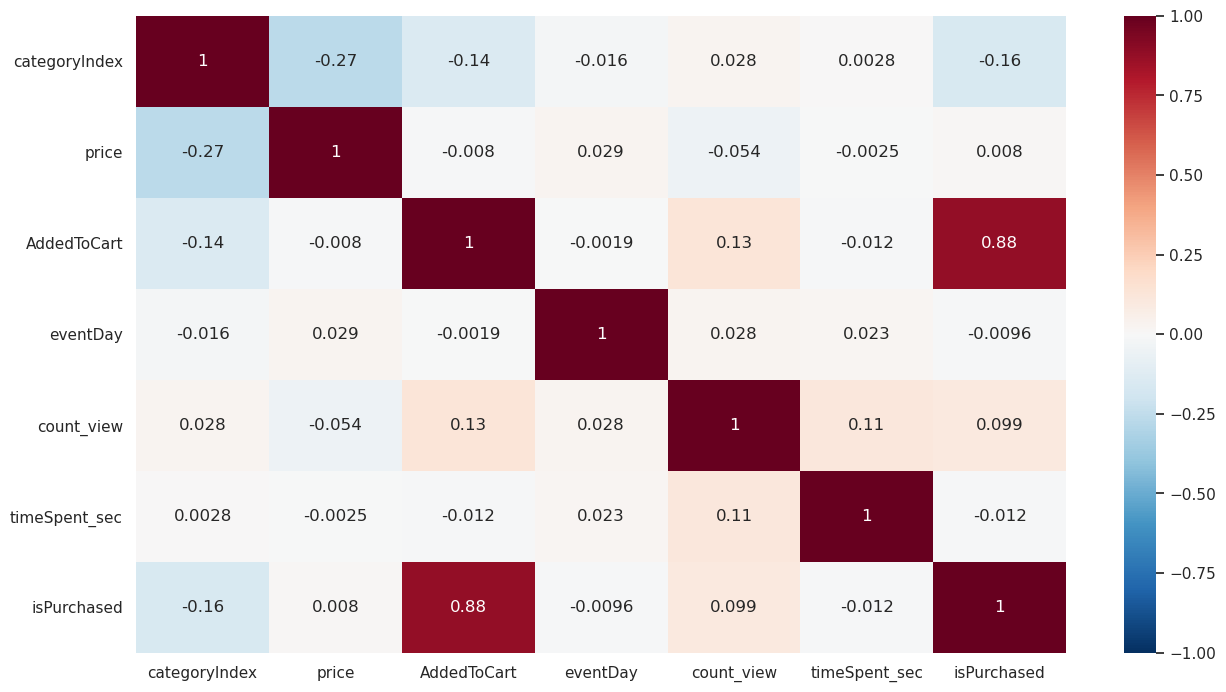

In [54]:
df_clf1 = df_clf.drop('user_session', 'product_id', 'user_id', 'event_time')

indexed_df = index_cat(df_clf1, 'category_code', 'categoryIndex')

feature_columns = ['categoryIndex', 'price','AddedToCart', 'eventDay', 'count_view', 'timeSpent_sec', 'isPurchased']
corr_matrix(indexed_df, feature_columns)

### two more attrib added

In [56]:
pur_new = spark.read.csv('purchased1/purchased_t.csv', header = True, schema = schema)
noPur_new = spark.read.csv('noPurchase1/noPurchase_t.csv', header = True, schema = schema)

In [9]:
schema_sampled = StructType([
    StructField("user_id", IntegerType(), True),
    StructField("event_time", TimestampType(), True),
    StructField("event_type", StringType(), True),
    StructField("product_id", IntegerType(), True),
    StructField("category_code", StringType(), True),
    StructField("price", FloatType(), True),
    StructField("user_session", StringType(), True)
])

sampled = spark.read.csv('sampled.csv', header = True, schema = schema_sampled)
sampled.createOrReplaceTempView('sampled')

#### multiChoice

In [45]:
# count how many products in the same category a user session has viewd
pro_session_cat  = spark.sql('''SELECT DISTINCT user_session, product_id, category_code
                                FROM sampled''')
pro_session_cat.show(5)

pro_session_cat.createOrReplaceGlobalTempView('pro_session_cat')
session_cat = spark.sql('''SELECT user_session, category_code, COUNT(category_code)
                           FROM global_temp.pro_session_cat
                           GROUP BY user_session, category_code''')
session_cat.show(5)

+--------------------+----------+-------------+
|        user_session|product_id|category_code|
+--------------------+----------+-------------+
|d989cae7-d1b1-4b1...|  28719130|      apparel|
|3cac16fa-ef90-452...|  16800039|   appliances|
|f4958ef1-433a-461...|   1801503|   appliances|
|6f608968-4ecb-4c2...|   1002544| construction|
|c3d1cc90-962d-429...|   4802594|        sport|
+--------------------+----------+-------------+
only showing top 5 rows



+--------------------+-------------+--------------------+
|        user_session|category_code|count(category_code)|
+--------------------+-------------+--------------------+
|177fd8ba-cd8e-4fa...|   appliances|                   6|
|d4046e83-5697-440...|         kids|                   5|
|8d5dc416-9d9b-405...|   appliances|                   4|
|1a50b919-1438-4e4...| construction|                   5|
|8015e4e3-d4a7-45a...| construction|                   2|
+--------------------+-------------+--------------------+
only showing top 5 rows



In [39]:
MultiChoice = session_cat.withColumn('multiChoice', when(col('count(category_code)') > 1, 1).otherwise(0))
MultiChoice.show(5)

+--------------------+-------------+--------------------+----------+
|        user_session|category_code|count(category_code)|multChoice|
+--------------------+-------------+--------------------+----------+
|177fd8ba-cd8e-4fa...|   appliances|                   6|         1|
|d4046e83-5697-440...|         kids|                   5|         1|
|8d5dc416-9d9b-405...|   appliances|                   4|         1|
|1a50b919-1438-4e4...| construction|                   5|         1|
|8015e4e3-d4a7-45a...| construction|                   2|         1|
+--------------------+-------------+--------------------+----------+
only showing top 5 rows



In [56]:
MultiChoice = MultiChoice.drop('count(category_code)')
df_clf = df_clf.join(MultiChoice, on = ['user_session','category_code'] , how = 'inner')
pur_new = pur_new.join(MultiChoice, on = ['user_session','category_code'] , how = 'inner')
noPur_new = noPur_new.join(MultiChoice, on = ['user_session','category_code'] , how = 'inner')

In [59]:
df_clf.corr('isPurchased', 'multiChoice')

-0.3173083199733119

#### purBefore

In [77]:
# count # times a user session has bought on the site up to the current row
purBefore =spark.sql('''
                         SELECT user_session, event_time,
                           COUNT(CASE WHEN event_type = 'purchase' THEN category_code END) 
                               OVER(PARTITION BY user_session ORDER BY event_time) AS countPurBefore
                         FROM sampled
                    ''' )
purBefore.show(5)

+--------------------+-------------------+--------------+
|        user_session|         event_time|countPurBefore|
+--------------------+-------------------+--------------+
|000005c1-b15b-4b6...|2020-03-15 10:46:00|             0|
|000013d3-9254-4f8...|2020-03-05 16:18:16|             0|
|000013d3-9254-4f8...|2020-03-05 16:19:02|             0|
|000013d3-9254-4f8...|2020-03-05 16:21:32|             0|
|0000199d-e75e-4e2...|2020-03-02 13:49:41|             0|
+--------------------+-------------------+--------------+
only showing top 5 rows



In [78]:
purBefore = purBefore.withColumn('countPurBefore', when(col('countPurBefore') > 0, col('countPurBefore')-1).otherwise(col('countPurBefore')))
purBefore = purBefore.withColumn('PurBefore', when(col('countPurBefore') >= 1, 1).otherwise(0))
purBefore = purBefore.drop('countPurBefore')
df_clf = df_clf.join(purBefore, on = ['user_session','event_time'] , how = 'inner')
df_clf.show(5)

+--------------------+-------------------+-------------+----------+---------+-------+-----------+--------+----------+-------------+-----------+-----------+---------+
|        user_session|         event_time|category_code|product_id|  user_id|  price|AddedToCart|eventDay|count_view|timeSpent_sec|isPurchased|multiChoice|PurBefore|
+--------------------+-------------------+-------------+----------+---------+-------+-----------+--------+----------+-------------+-----------+-----------+---------+
|00002b33-422d-4a0...|2020-03-09 16:29:11| construction|  19100023|517463118|  65.48|          1|       9|         2|          589|          1|          1|        0|
|00038685-f622-415...|2020-03-18 11:27:51| construction|   1005284|619836581|2161.96|          0|      18|         1|            0|          0|          1|        0|
|00038685-f622-415...|2020-03-18 11:35:28| construction|   1004767|619836581| 240.78|          1|      18|         1|          294|          1|          1|        0|
|000

In [79]:
pur_new = pur_new.join(purBefore, on = ['user_session','event_time'] , how = 'inner')
noPur_new = noPur_new.join(purBefore, on = ['user_session','event_time'] , how = 'inner')

#### output

In [58]:
df_clf = df_clf.drop('event_time')
pur_new = pur_new.drop('event_time')
noPur_new = noPur_new.drop('event_time')

In [27]:
df_clf.coalesce(1).write.csv('df_clf_3', header=True)
pur_new.coalesce(1).write.csv('pur_new', header=True)
noPur_new.coalesce(1).write.csv('noPur_new', header=True)

### new correlation matrix

In [7]:
schema_new = StructType([
    StructField("user_session", StringType(), True),
    StructField("category_code", StringType(), True),
    StructField("product_id", IntegerType(), True),
    StructField("user_id", IntegerType(), True),
    StructField("price", FloatType(), True),
    StructField("AddedToCart", IntegerType(), True),
    StructField("eventDay", IntegerType(), True),
    StructField("count_view", IntegerType(), True),
    StructField("timeSpent_sec", IntegerType(), True),
    StructField("isPurchased", IntegerType(), True),
    StructField("multiChoice", IntegerType(), True),
    StructField("PurBefore", IntegerType(), True),
])


pur_new = spark.read.csv('pur_new_corr.csv', header = True, schema = schema_new)
pur_new.show(3)
noPur_new = spark.read.csv('noPur_new_corr.csv', header = True, schema = schema_new)
noPur_new.show(3)
bal_df = spark.read.csv('balanced_df.csv', header = True, schema = schema_new)
bal_df.show(3)

+--------------------+-------------+----------+---------+------+-----------+--------+----------+-------------+-----------+-----------+---------+
|        user_session|category_code|product_id|  user_id| price|AddedToCart|eventDay|count_view|timeSpent_sec|isPurchased|multiChoice|PurBefore|
+--------------------+-------------+----------+---------+------+-----------+--------+----------+-------------+-----------+-----------+---------+
|0039f13c-a89f-495...|        sport|   4804056|588826226|169.61|          1|      17|         1|           97|          1|          0|        0|
|00c3bf9d-2ad4-4cc...| construction|   1003319|513785612|900.64|          1|       7|         1|           21|          1|          0|        0|
|01453a19-68fa-4c1...| construction|   1004767|623718774|240.88|          1|       9|         2|           95|          1|          0|        1|
+--------------------+-------------+----------+---------+------+-----------+--------+----------+-------------+-----------+--------

In [8]:
unbal_df = pur_new.unionAll(noPur_new)

In [9]:
ttl_n = bal_df.count()
bal_df.groupby(col('isPurchased')).count().withColumn('pct', col('count')/ttl_n).show()

+-----------+------+------------------+
|isPurchased| count|               pct|
+-----------+------+------------------+
|          1|122537|0.4998613048763574|
|          0|122605|0.5001386951236426|
+-----------+------+------------------+



In [10]:
ttl_n = unbal_df.count()

unbal_df.groupby(col('isPurchased')).count().withColumn('pct', col('count')/ttl_n).show()

+-----------+-------+------------------+
|isPurchased|  count|               pct|
+-----------+-------+------------------+
|          1| 122537|0.0351360371979715|
|          0|3364965|0.9648639628020285|
+-----------+-------+------------------+



+-------------+------+-----------+--------+----------+-------------+-----------+-----------+---------+-------------+
|category_code| price|AddedToCart|eventDay|count_view|timeSpent_sec|isPurchased|multiChoice|PurBefore|categoryIndex|
+-------------+------+-----------+--------+----------+-------------+-----------+-----------+---------+-------------+
|        sport|169.61|          1|      17|         1|           97|          1|          0|        0|          4.0|
|  electronics|180.18|          0|      28|         1|            0|          0|          1|        0|          2.0|
| construction|900.64|          1|       7|         1|           21|          1|          0|        0|          0.0|
+-------------+------+-----------+--------+----------+-------------+-----------+-----------+---------+-------------+
only showing top 3 rows



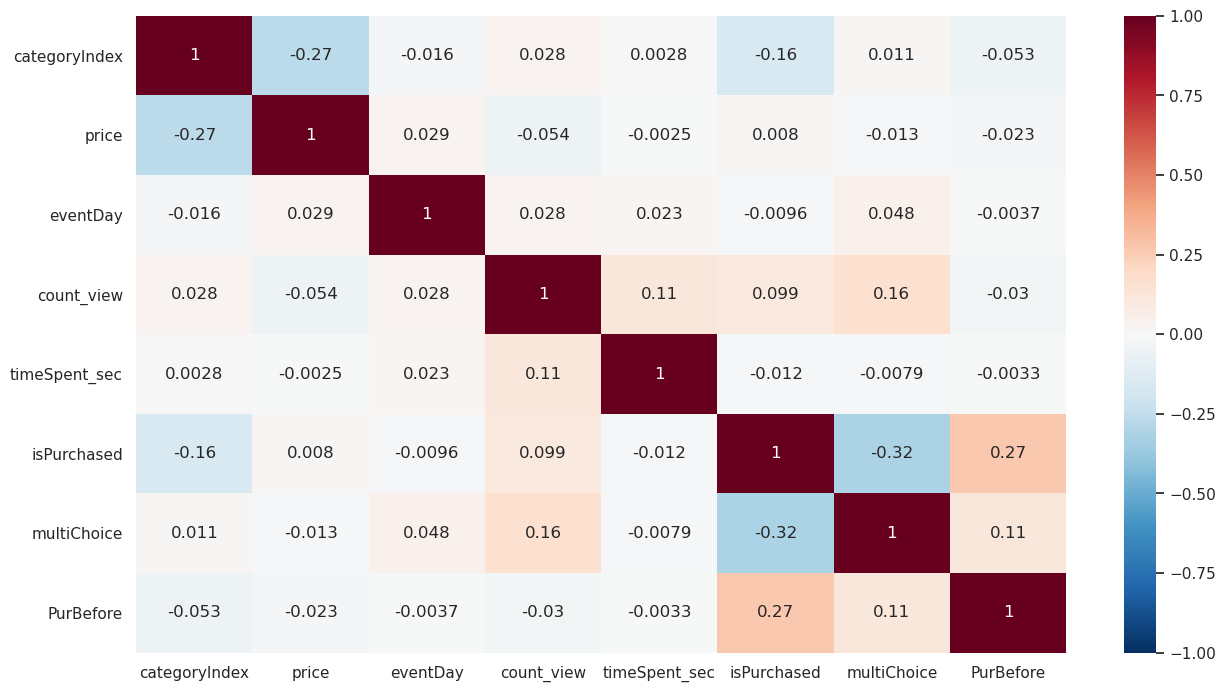

In [11]:
# for balance df df_clf_new
bal_df_dropped = bal_df.drop('user_session', 'product_id', 'user_id')
bal_clf = index_cat(bal_df_dropped, 'category_code', 'categoryIndex')

feature_columns = ['categoryIndex', 'price', 'eventDay', 'count_view', 'timeSpent_sec', 'isPurchased', 'multiChoice', 'PurBefore']
corr_matrix(bal_clf, feature_columns)

+-------------+------+-----------+--------+----------+-------------+-----------+-----------+---------+-------------+
|category_code| price|AddedToCart|eventDay|count_view|timeSpent_sec|isPurchased|multiChoice|PurBefore|categoryIndex|
+-------------+------+-----------+--------+----------+-------------+-----------+-----------+---------+-------------+
|        sport|169.61|          1|      17|         1|           97|          1|          0|        0|          4.0|
| construction|900.64|          1|       7|         1|           21|          1|          0|        0|          0.0|
| construction|240.88|          1|       9|         2|           95|          1|          0|        1|          0.0|
+-------------+------+-----------+--------+----------+-------------+-----------+-----------+---------+-------------+
only showing top 3 rows



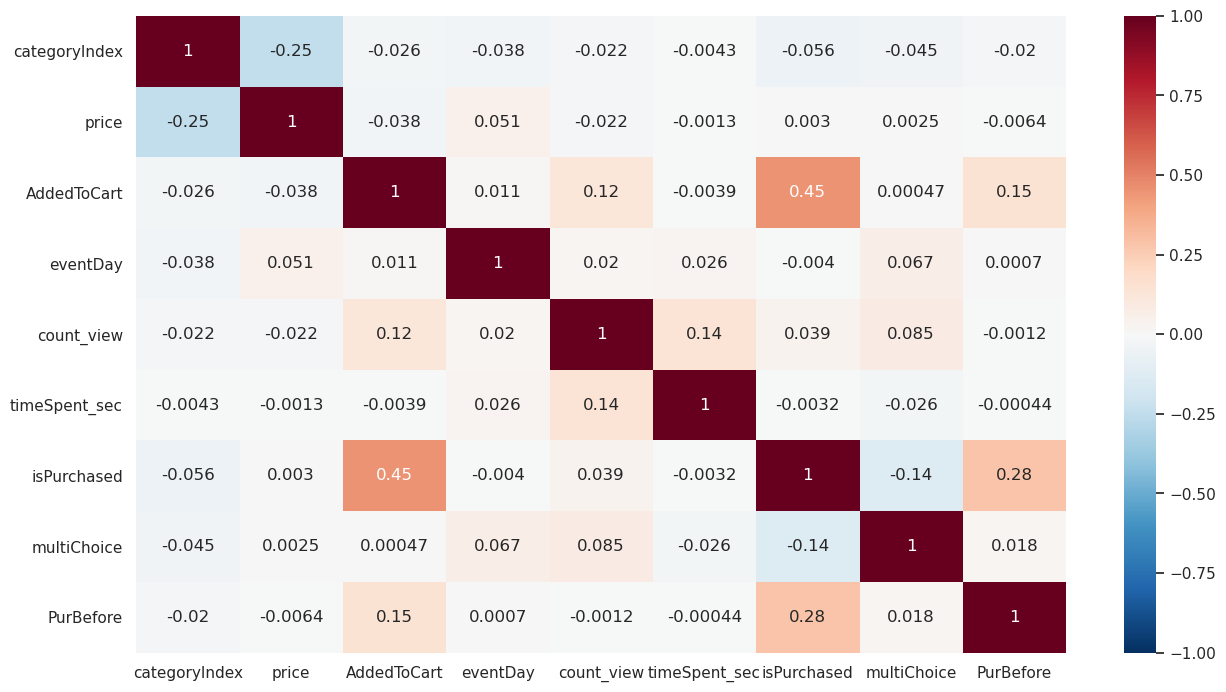

In [12]:
# for unbalanced df
unbal_df_dropped = unbal_df.drop('user_session', 'product_id', 'user_id')
unbal_clf = index_cat(unbal_df_dropped, 'category_code', 'categoryIndex')

feature_columns = ['categoryIndex', 'price', 'AddedToCart', 'eventDay', 'count_view', 'timeSpent_sec', 'isPurchased', 'multiChoice', 'PurBefore']
corr_matrix(unbal_clf, feature_columns)

### classification for balanced data

In [13]:
bal_clf.show()

+-------------+-------+-----------+--------+----------+-------------+-----------+-----------+---------+-------------+
|category_code|  price|AddedToCart|eventDay|count_view|timeSpent_sec|isPurchased|multiChoice|PurBefore|categoryIndex|
+-------------+-------+-----------+--------+----------+-------------+-----------+-----------+---------+-------------+
|        sport| 169.61|          1|      17|         1|           97|          1|          0|        0|          4.0|
|  electronics| 180.18|          0|      28|         1|            0|          0|          1|        0|          2.0|
| construction| 900.64|          1|       7|         1|           21|          1|          0|        0|          0.0|
| construction| 240.88|          1|       9|         2|           95|          1|          0|        1|          0.0|
|  electronics| 175.29|          0|       3|         1|            0|          0|          1|        0|          2.0|
| construction| 733.35|          1|       5|         1| 

In [14]:
# Split the data into training and test sets (30% held out for testing)
trainingData, testData = bal_clf.randomSplit([0.7, 0.3],seed=150)

In [15]:
# the selected features
features = ['categoryIndex', 'price', 'eventDay', 'count_view', 'timeSpent_sec', 'multiChoice', 'PurBefore']

#converting the features columns to 1 feature column using VectorAssembler
vectorassembler = VectorAssembler(inputCols = features, outputCol= 'assemblerfeatures')

In [16]:
pipeline_preprocessing = Pipeline(stages=[vectorassembler])

In [17]:
#Preprocess the training samples and apply the same pipeline model to the test set
model_preprossing = pipeline_preprocessing.fit(trainingData) 

X_y_train = model_preprossing.transform(trainingData) 

X_y_test = model_preprossing.transform(testData)

In [18]:
X_y_train.show()

+-------------+-----+-----------+--------+----------+-------------+-----------+-----------+---------+-------------+--------------------+
|category_code|price|AddedToCart|eventDay|count_view|timeSpent_sec|isPurchased|multiChoice|PurBefore|categoryIndex|   assemblerfeatures|
+-------------+-----+-----------+--------+----------+-------------+-----------+-----------+---------+-------------+--------------------+
|  accessories|  0.0|          0|       2|         1|            0|          0|          1|        0|          9.0|[9.0,0.0,2.0,1.0,...|
|  accessories|  0.0|          0|      22|         1|            0|          0|          0|        0|          9.0|(7,[0,2,3],[9.0,2...|
|  accessories|  0.0|          1|       8|         2|           15|          0|          1|        0|          9.0|[9.0,0.0,8.0,2.0,...|
|  accessories| 1.98|          0|      30|         1|            0|          0|          0|        0|          9.0|[9.0,1.9800000190...|
|  accessories| 1.98|          0|      31

In [22]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Broadcasting large task binary with size.*MiB")

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(labelCol="isPurchased", featuresCol="assemblerfeatures")

# Create an evaluator
evaluator = BinaryClassificationEvaluator(labelCol="isPurchased", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Create a parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(rf_classifier.numTrees, [10, 20, 30]) \
    .addGrid(rf_classifier.maxDepth, [5, 10, 15]) \
    .build()

# Create a pipeline
pipeline = Pipeline(stages=[vectorassembler, rf_classifier])

# Create a cross-validator
cross_validator = CrossValidator(estimator=pipeline,
                                 estimatorParamMaps=param_grid,
                                 evaluator=evaluator,
                                 numFolds=3)

# Fit the cross-validator to the training data
cv_model = cross_validator.fit(trainingData)

# Get the best model from the cross-validator
best_model = cv_model.bestModel

# Access the stages of the best model
stages = best_model.stages

# Extract the RandomForestClassifier stage (should be the last one)
best_rf_classifier = stages[-1]

# Get the best parameters
best_num_trees = best_rf_classifier.getNumTrees
best_max_depth = best_rf_classifier.getMaxDepth()

print(f"Best Parameters - Num Trees: {best_num_trees}, Max Depth: {best_max_depth}")

# Make predictions on the test data
predictions = best_model.transform(testData)

# Evaluate the model performance
auc = evaluator.evaluate(predictions)
print(f"Area under ROC: {auc}")

23/12/16 08:40:21 WARN DAGScheduler: Broadcasting large task binary with size 1219.7 KiB
23/12/16 08:40:22 WARN DAGScheduler: Broadcasting large task binary with size 1694.5 KiB
23/12/16 08:40:23 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/12/16 08:40:25 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/16 08:40:27 WARN DAGScheduler: Broadcasting large task binary with size 1747.3 KiB
23/12/16 08:40:40 WARN DAGScheduler: Broadcasting large task binary with size 1112.5 KiB
23/12/16 08:40:50 WARN DAGScheduler: Broadcasting large task binary with size 1112.5 KiB
23/12/16 08:40:51 WARN DAGScheduler: Broadcasting large task binary with size 1617.5 KiB
23/12/16 08:40:53 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/16 08:40:54 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/12/16 08:40:56 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
23/12/16 08:41:00 WARN DAGScheduler:

Best Parameters - Num Trees: 30, Max Depth: 15


23/12/16 08:47:34 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


Area under ROC: 0.9810402351082674


In [23]:
# Creating and fitting the RFC model with 5 tree and default maxDeapth value of 5
rf_n5 = RandomForestClassifier(labelCol="isPurchased", featuresCol="assemblerfeatures", numTrees=5)
model_rf_n5 = rf_n5.fit(X_y_train)

In [24]:
# models prediction
pred_rf_n5 = model_rf_n5.transform(X_y_test)

In [25]:
# evaluate the model 
evaluator = BinaryClassificationEvaluator(labelCol="isPurchased", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
print("RandomForest_n5", "areaUnderROC", evaluator.evaluate(pred_rf_n5))
evaluator = BinaryClassificationEvaluator(labelCol="isPurchased", rawPredictionCol="rawPrediction", metricName="areaUnderPR")
print("RandomForest_n5", "Area under the precision-recall curve", evaluator.evaluate(pred_rf_n5))

RandomForest_n5 areaUnderROC 0.9768388364651718


RandomForest_n5 Area under the precision-recall curve 0.9753961349846771


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix')

Text(0.5, 32.249999999999986, 'Predicted Label')

Text(66.25, 0.5, 'True Label')

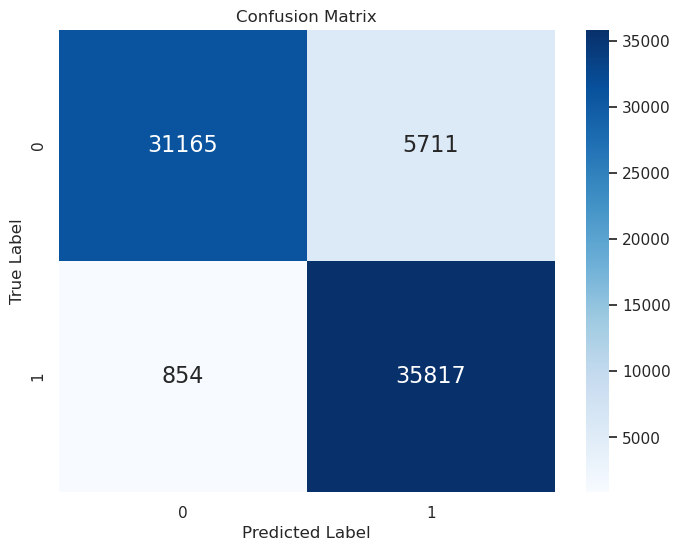

0.9107373516254912 0.8624783278751685


In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
 
predicted_labels = np.array(pred_rf_n5.select('prediction').rdd.map(lambda x: x[0]).collect())
labels = np.array(pred_rf_n5.select('isPurchased').rdd.map(lambda x: x[0]).collect())
 
# CConfusion matrix
conf_matrix = confusion_matrix(labels, predicted_labels)
 
# Display the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
 
accuracy = accuracy_score(labels, predicted_labels)
precision = precision_score(labels, predicted_labels)
print (accuracy, precision)

In [27]:
from sklearn.metrics import classification_report
print( classification_report(labels, predicted_labels) )

              precision    recall  f1-score   support

           0       0.97      0.85      0.90     36876
           1       0.86      0.98      0.92     36671

    accuracy                           0.91     73547
   macro avg       0.92      0.91      0.91     73547
weighted avg       0.92      0.91      0.91     73547



<Figure size 1000x600 with 0 Axes>

<BarContainer object of 7 artists>

Text(0.5, 0, 'Importance')

Text(0.5, 1.0, 'RandomForestClassifier Feature Importance')

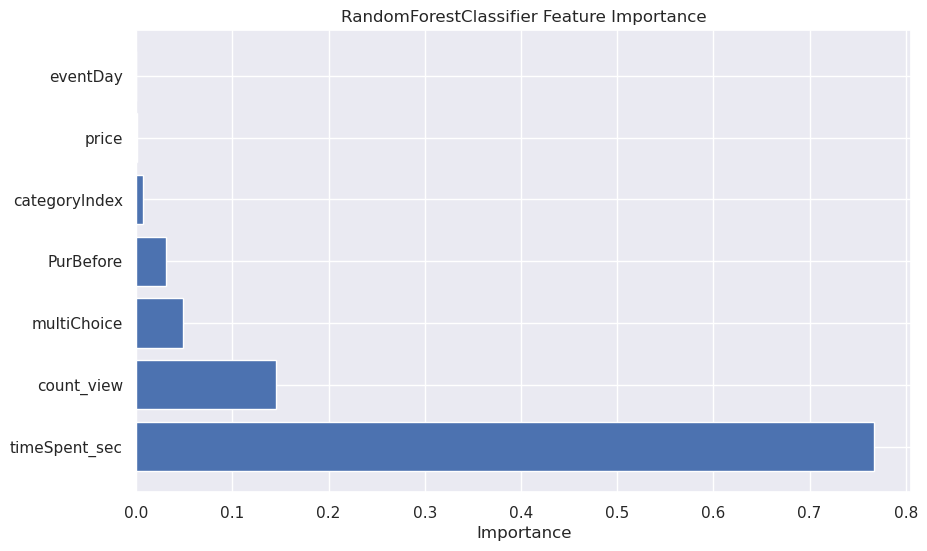

In [28]:
# Get feature importance
feature_importance = model_rf_n5.featureImportances.toArray()

# Create a Pandas DataFrame for better visualization
import pandas as pd
feature_importance_df = pd.DataFrame({"Feature": features, "Importance": feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.xlabel("Importance")
plt.title("RandomForestClassifier Feature Importance")
plt.show()

In [29]:
# Creating and fitting the model with hyperparameter suggested by GridSearch
rf_n30 = RandomForestClassifier(labelCol="isPurchased", featuresCol="assemblerfeatures", numTrees=30, maxDepth = 15)
model_rf_n30 = rf_n30.fit(X_y_train)

23/12/16 08:56:13 WARN DAGScheduler: Broadcasting large task binary with size 1248.1 KiB
23/12/16 08:56:17 WARN DAGScheduler: Broadcasting large task binary with size 1885.0 KiB
23/12/16 08:56:21 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/12/16 08:56:26 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
23/12/16 08:56:32 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
23/12/16 08:56:38 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
23/12/16 08:56:43 WARN DAGScheduler: Broadcasting large task binary with size 1114.0 KiB
23/12/16 08:56:45 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
23/12/16 08:56:50 WARN DAGScheduler: Broadcasting large task binary with size 1368.5 KiB


In [33]:
# models prediction
pred_rf_n30 = model_rf_n30.transform(X_y_test)

23/12/16 09:01:01 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix')

Text(0.5, 32.249999999999986, 'Predicted Label')

Text(66.25, 0.5, 'True Label')

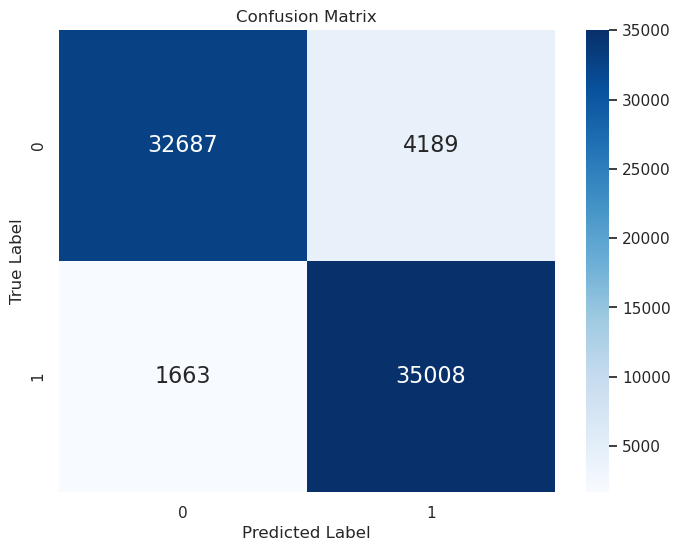

0.9204318327056168 0.8931295762430799


In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
 
predicted_labels_n30 = np.array(pred_rf_n30.select('prediction').rdd.map(lambda x: x[0]).collect())
labels_n30 = np.array(pred_rf_n30.select('isPurchased').rdd.map(lambda x: x[0]).collect())
 
# CConfusion matrix
conf_matrix = confusion_matrix(labels_n30, predicted_labels_n30)
 
# Display the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
 
accuracy = accuracy_score(labels_n30, predicted_labels_n30)
precision = precision_score(labels_n30, predicted_labels_n30)
print (accuracy, precision)

In [38]:
from sklearn.metrics import classification_report
print( classification_report(labels_n30, predicted_labels_n30) )

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     36876
           1       0.89      0.95      0.92     36671

    accuracy                           0.92     73547
   macro avg       0.92      0.92      0.92     73547
weighted avg       0.92      0.92      0.92     73547



<Figure size 1000x600 with 0 Axes>

<BarContainer object of 7 artists>

Text(0.5, 0, 'Importance')

Text(0.5, 1.0, 'RandomForestClassifier Feature Importance')

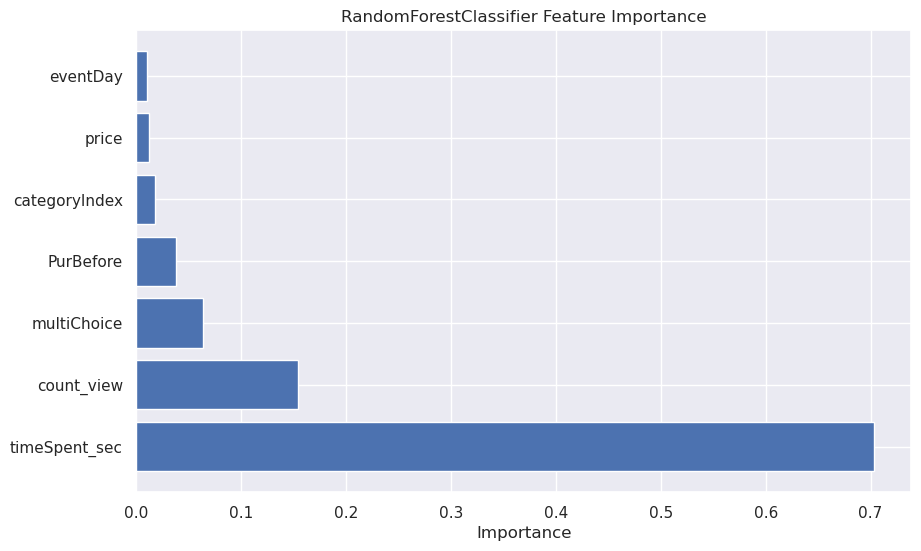

In [39]:
# Get feature importance
feature_importance = model_rf_n30.featureImportances.toArray()

# Create a Pandas DataFrame for better visualization
import pandas as pd
feature_importance_df = pd.DataFrame({"Feature": features, "Importance": feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.xlabel("Importance")
plt.title("RandomForestClassifier Feature Importance")
plt.show()